# Date Fruit Classification along with EDA and Model Building

## Importing Libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from tensorflow import keras
import tensorflow as tf

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, accuracy_score, classification_report

pd.set_option('display.max_columns', None)

2024-05-16 19:48:51.259173: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 19:48:52.909213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Loading Dataset

In [85]:
fruit_date = pd.read_excel("./dataset/Date_Fruit_Datasets.xlsx")

## Quick Look at dataset

In [3]:
fruit_date.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,MeanRR,MeanRG,MeanRB,StdDevRR,StdDevRG,StdDevRB,SkewRR,SkewRG,SkewRB,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB,Class
0,422163,2378.908,837.8484,645.6693,0.6373,733.1539,0.9947,424428,0.7831,1.2976,0.9374,0.8750,0.0020,0.0015,0.7657,0.9936,117.4466,109.9085,95.6774,26.5152,23.0687,30.1230,-0.5661,-0.0114,0.6019,3.2370,2.9574,4.2287,-59191263232,-50714214400,-39922372608,58.7255,54.9554,47.8400,BERHI
1,338136,2085.144,723.8198,595.2073,0.5690,656.1464,0.9974,339014,0.7795,1.2161,0.9773,0.9065,0.0021,0.0018,0.8218,0.9993,100.0578,105.6314,95.6610,27.2656,23.4952,28.1229,-0.2328,0.1349,0.4134,2.6228,2.6350,3.1704,-34233065472,-37462601728,-31477794816,50.0259,52.8168,47.8315,BERHI
2,526843,2647.394,940.7379,715.3638,0.6494,819.0222,0.9962,528876,0.7657,1.3150,0.9446,0.8706,0.0018,0.0014,0.7580,0.9968,130.9558,118.5703,103.8750,29.7036,24.6216,33.9053,-0.7152,-0.1059,0.9183,3.7516,3.8611,4.7192,-93948354560,-74738221056,-60311207936,65.4772,59.2860,51.9378,BERHI
3,416063,2351.210,827.9804,645.2988,0.6266,727.8378,0.9948,418255,0.7759,1.2831,0.9458,0.8791,0.0020,0.0016,0.7727,0.9915,86.7798,88.2531,82.3751,28.7288,24.4905,30.3955,0.4584,1.2917,1.8028,5.0401,8.6136,8.2618,-32074307584,-32060925952,-29575010304,43.3900,44.1259,41.1882,BERHI
4,347562,2160.354,763.9877,582.8359,0.6465,665.2291,0.9908,350797,0.7569,1.3108,0.9358,0.8707,0.0022,0.0017,0.7582,0.9938,105.5484,101.8132,85.3342,30.3205,25.0291,27.1741,-0.3552,0.2101,0.8865,2.7016,2.9761,4.4146,-39980974080,-35980042240,-25593278464,52.7743,50.9080,42.6666,BERHI


In [4]:
fruit_date.shape

(898, 35)

Here's a quick overview of the columns in the fruit dataset:

1. **AREA**: This represents the area of the fruit's shape.

2. **PERIMETER**: This represents the perimeter or the total length of the boundary of the fruit.

3. **MAJOR_AXIS**: This refer to the length of the longer axis of the fruit.

4. **MINOR_AXIS**: This the length of the shorter axis of the fruit/

5. **ECCENTRICITY**: This is the measure of how much the fruit's shape deviates from a perfect circle. It indicates how elongated or stretched the shape is.

6. **EQDIASQ**: It's unclear what this abbreviation stands. It might be a specialized measurement related to the fruit's shape.

7. **SOLIDITY**: It indicates how compact the fruit is. 

8. **CONVEX_AREA**: This is the area of the smallest convex polygon that can contain the fruit. It relates to the fruit's overall shape. 

9. **EXTENT**: Extent could refer to the ratio of the pixel area of the fruit to the bounding box area. It provides insights into how much the fruit fills its bounding box.

10. **ASPECT_RATIO**: This is the ratio of the major axis length to the minor axis length. It provides information about the elongation of the fruit.

11. **ROUNDNESS**: Roundness could be calculated as the reciprocal of the aspect ratio, indicating how closely the fruit resembles a perfect circle.

12. **COMPACTNESS**: This is a measure of how closely the fruit's shape approaches that of a circle. 

13. **SHAPEFACTOR_1 to SHAPEFACTOR_4**: These are likely different shape factors or indices that capture various aspects of the fruit's shape. The specific meanings of these factors depends on the context and the formula used to calculate them.

14. **MeanRR, MeanRG, MeanRB**: These could represent the mean values of the red, green, and blue color channels, respectively, in the fruit's image or color data.

15. **StdDevRR, StdDevRG, StdDevRB**: These might represent the standard deviations of the red, green, and blue color channels, indicating the color variation within the fruit's image.

16. **SkewRR, SkewRG, SkewRB**: These could be skewness values indicating the asymmetry of the color distribution in each color channel.

17. **KurtosisRR, KurtosisRG, KurtosisRB**: These could represent kurtosis values, which describe the shape of the color distribution in each channel.

18. **EntropyRR, EntropyRG, EntropyRB**: These likely represent entropy values, which measure the randomness or uncertainty in the color distribution of each channel.

19. **ALLdaub4RR, ALLdaub4RG, ALLdaub4RB**: These could be coefficients or features obtained through a specific transformation or analysis. 

20. **Class**: This column represents the class or category to which each fruit sample belongs.

In [5]:
# quick description of the dataset
fruit_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           898 non-null    int64  
 1   PERIMETER      898 non-null    float64
 2   MAJOR_AXIS     898 non-null    float64
 3   MINOR_AXIS     898 non-null    float64
 4   ECCENTRICITY   898 non-null    float64
 5   EQDIASQ        898 non-null    float64
 6   SOLIDITY       898 non-null    float64
 7   CONVEX_AREA    898 non-null    int64  
 8   EXTENT         898 non-null    float64
 9   ASPECT_RATIO   898 non-null    float64
 10  ROUNDNESS      898 non-null    float64
 11  COMPACTNESS    898 non-null    float64
 12  SHAPEFACTOR_1  898 non-null    float64
 13  SHAPEFACTOR_2  898 non-null    float64
 14  SHAPEFACTOR_3  898 non-null    float64
 15  SHAPEFACTOR_4  898 non-null    float64
 16  MeanRR         898 non-null    float64
 17  MeanRG         898 non-null    float64
 18  MeanRB    

All columns except the 'Class' column contain numerical data. The 'Class' column contains the target variable or labels that we aim to predict based on the features.

We can see that data does not contain any missing values because all the columns have 898 non-null entries and shape of is (898, 35). 
So, we can directly move to EDA.

In [6]:
# Summary statistics of the dataset
fruit_date.describe()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,MeanRR,MeanRG,MeanRB,StdDevRR,StdDevRG,StdDevRB,SkewRR,SkewRG,SkewRB,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,8.980000e+02,8.980000e+02,8.980000e+02,898.000000,898.000000,898.000000
mean,298295.207127,2057.660953,750.811994,495.872785,0.737468,604.577938,0.981840,303845.592428,0.736267,2.131102,0.857720,0.807190,0.003428,0.001794,0.655420,0.988680,100.165885,97.609401,96.194889,29.047436,26.383362,26.148330,0.089266,0.564139,0.250518,4.247845,5.110894,3.780928,-3.185021e+10,-2.901860e+10,-2.771876e+10,50.082888,48.805681,48.098393
std,107245.205337,410.012459,144.059326,114.268917,0.088727,119.593888,0.018157,108815.656947,0.053745,17.820778,0.070839,0.062175,0.020456,0.000428,0.094314,0.020473,32.126549,28.251801,21.627409,6.306931,5.462164,4.905078,0.943285,1.039813,0.632918,2.892357,3.745463,2.049831,2.037241e+10,1.712952e+10,1.484137e+10,16.063125,14.125911,10.813862
min,1987.000000,911.828000,336.722700,2.283200,0.344800,50.298400,0.836600,2257.000000,0.512300,1.065300,0.004800,0.041100,0.001700,0.001100,0.001700,0.756800,30.382600,41.048000,44.256900,7.303800,8.655700,5.148600,-1.724200,-1.834400,-1.029100,1.708200,1.607600,1.767200,-1.091224e+11,-9.261697e+10,-8.747177e+10,15.191100,20.524700,22.130000
25%,206948.000000,1726.091500,641.068650,404.684375,0.685625,513.317075,0.978825,210022.750000,0.705875,1.373725,0.827750,0.768050,0.002200,0.001500,0.589975,0.989300,76.448000,77.306125,78.502375,24.901525,22.289650,22.890975,-0.549900,-0.230200,-0.196950,2.536625,2.508850,2.577275,-4.429444e+10,-3.894638e+10,-3.564534e+10,38.224425,38.654525,39.250725
50%,319833.000000,2196.345450,791.363400,495.054850,0.754700,638.140950,0.987300,327207.000000,0.746950,1.524150,0.867750,0.804950,0.002600,0.001600,0.647950,0.993600,107.682450,100.676000,99.225600,29.709450,25.638300,26.469000,-0.162700,0.243750,0.135550,3.069800,3.127800,3.080700,-2.826156e+10,-2.620990e+10,-2.392928e+10,53.841300,50.337800,49.614100
75%,382573.000000,2389.716575,858.633750,589.031700,0.802150,697.930525,0.991800,388804.000000,0.775850,1.674750,0.899500,0.848875,0.003200,0.002075,0.720625,0.996400,126.127450,119.159600,113.332250,33.274375,29.905325,29.482375,0.471025,1.406550,0.593950,4.449850,7.320400,4.283125,-1.460482e+10,-1.433105e+10,-1.660367e+10,63.063350,59.573600,56.666675
max,546063.000000,2811.997100,1222.723000,766.453600,1.000000,833.827900,0.997400,552598.000000,0.856200,535.525700,0.977300,0.968100,0.615400,0.004300,0.937300,0.999500,159.649400,166.135400,148.211400,48.571200,45.510700,42.422800,3.223600,3.697100,3.092300,26.171100,26.736700,32.249500,-1.627316e+08,-5.627727e+08,-4.370435e+08,79.828900,83.064900,74.104600


## Visualizing the Data

In [8]:
fruit_date_1 = fruit_date.copy()

### Correlation Matrix

In [9]:
corr_mat = fruit_date_1.corr(numeric_only=True)
corr_mat = corr_mat.apply(lambda x: round(x, 1))

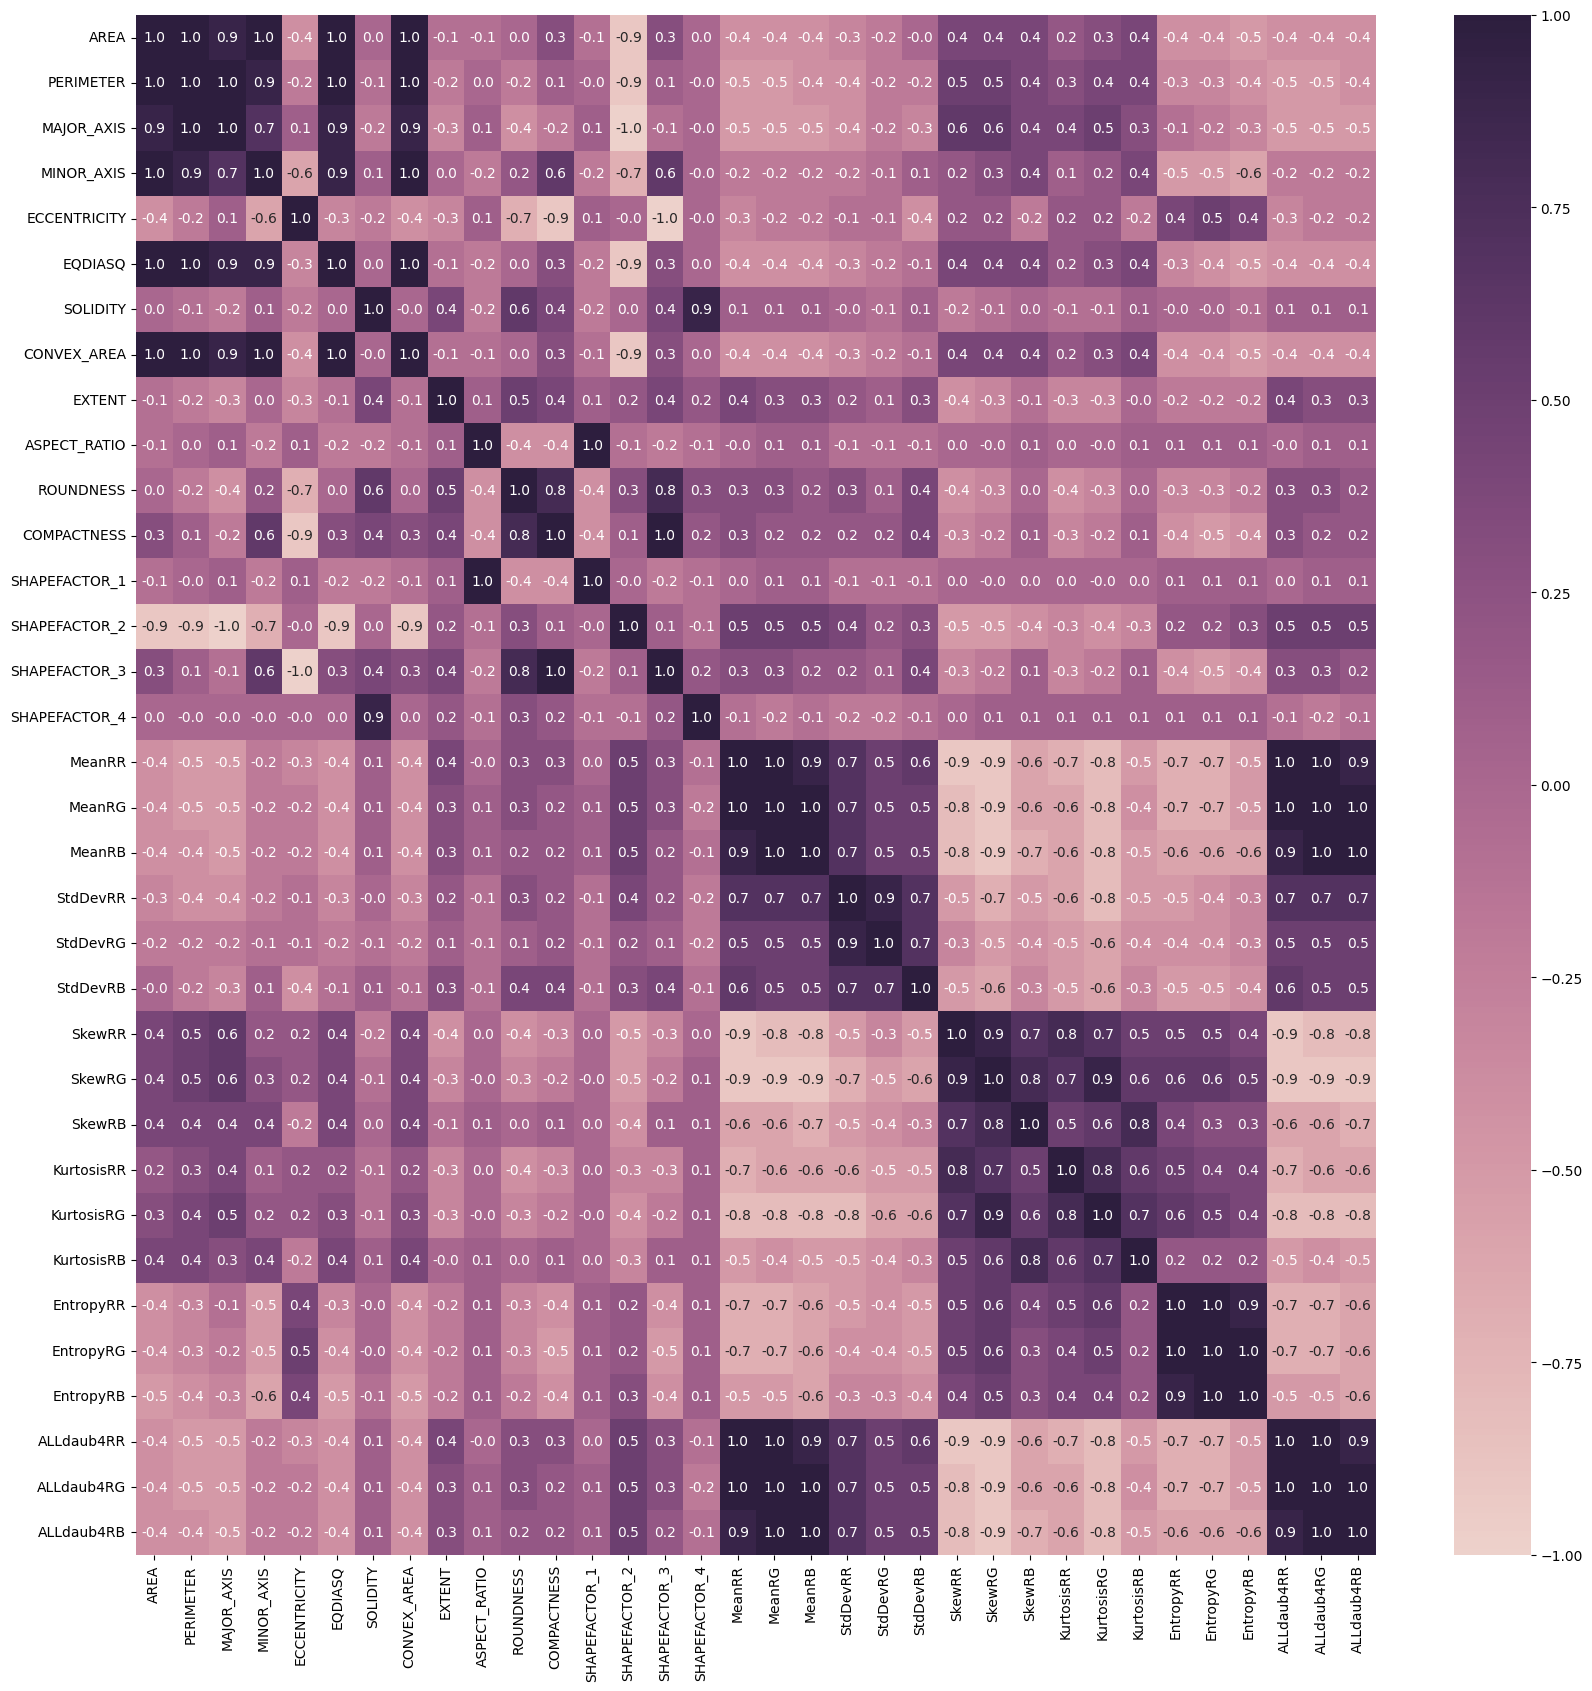

In [11]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_mat, fmt=".1f", annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

Some features are highly correlated to each other. Let's remove multi-collinearity from the data by removing highly correlated features. Removing feautures whose correlation is 1 or 0.9

In [12]:
fruit_date_2 = fruit_date_1.drop(["PERIMETER", "MAJOR_AXIS", "MINOR_AXIS", "EQDIASQ", "CONVEX_AREA","SHAPEFACTOR_1", "SHAPEFACTOR_4", "COMPACTNESS","MeanRG", "MeanRB", "StdDevRG", "SkewRG", "EntropyRG", "EntropyRB", "ALLdaub4RR", "ALLdaub4RG", "ALLdaub4RB"], axis=1)

In [13]:
corr_mat = fruit_date_2.corr(numeric_only=True).apply(lambda x: round(x, 1))

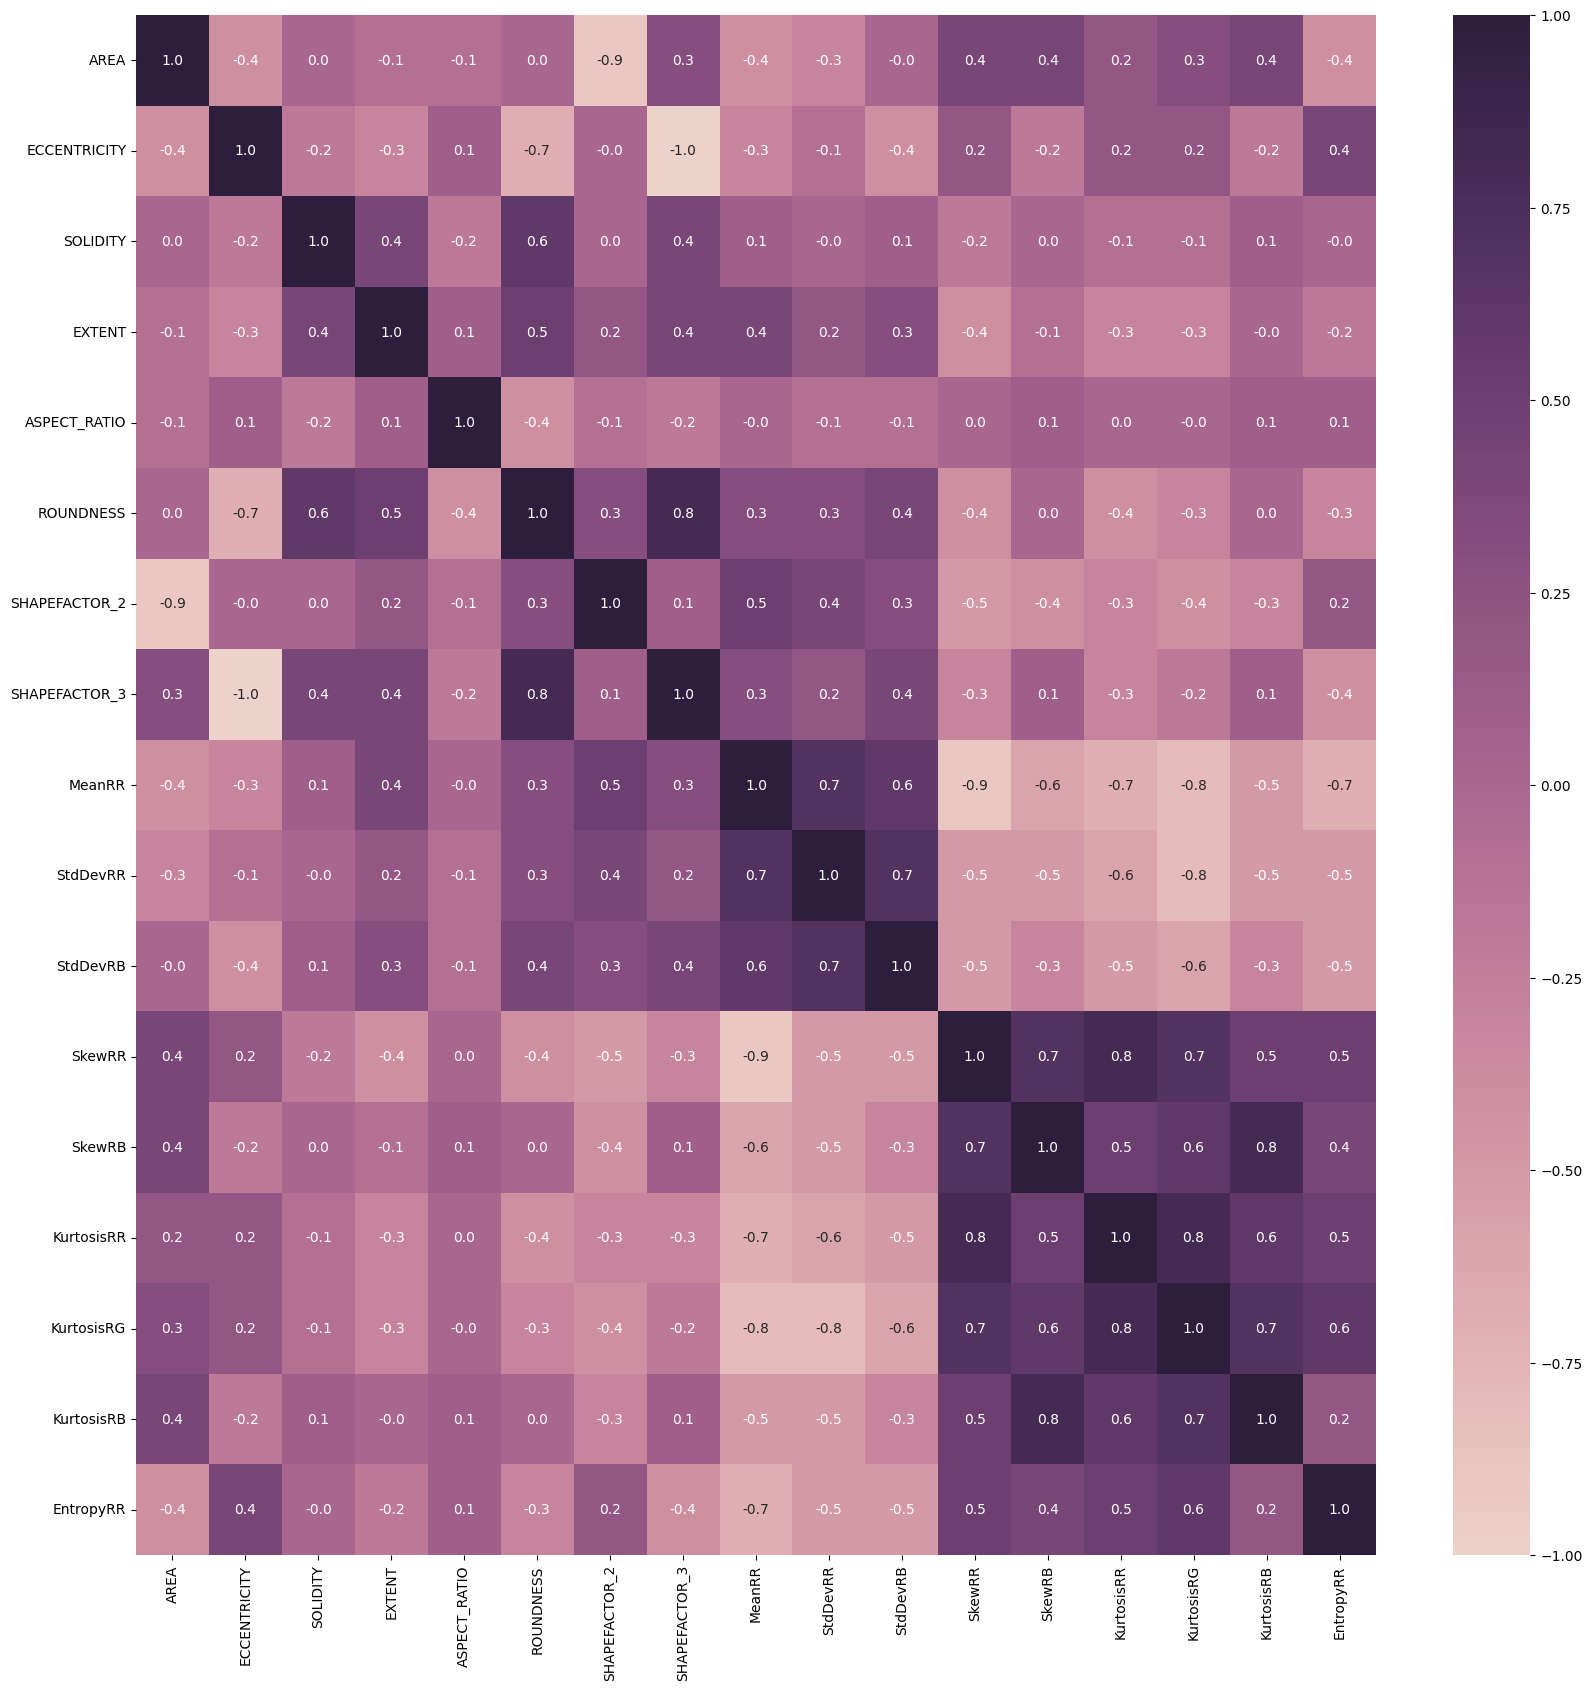

In [14]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_mat, fmt=".1f", annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Correlation Matrix after dropping some columns")
plt.show()

### Histogram of Features

Let's plot histograms for all the features in the dataset.

<Figure size 2000x2000 with 0 Axes>

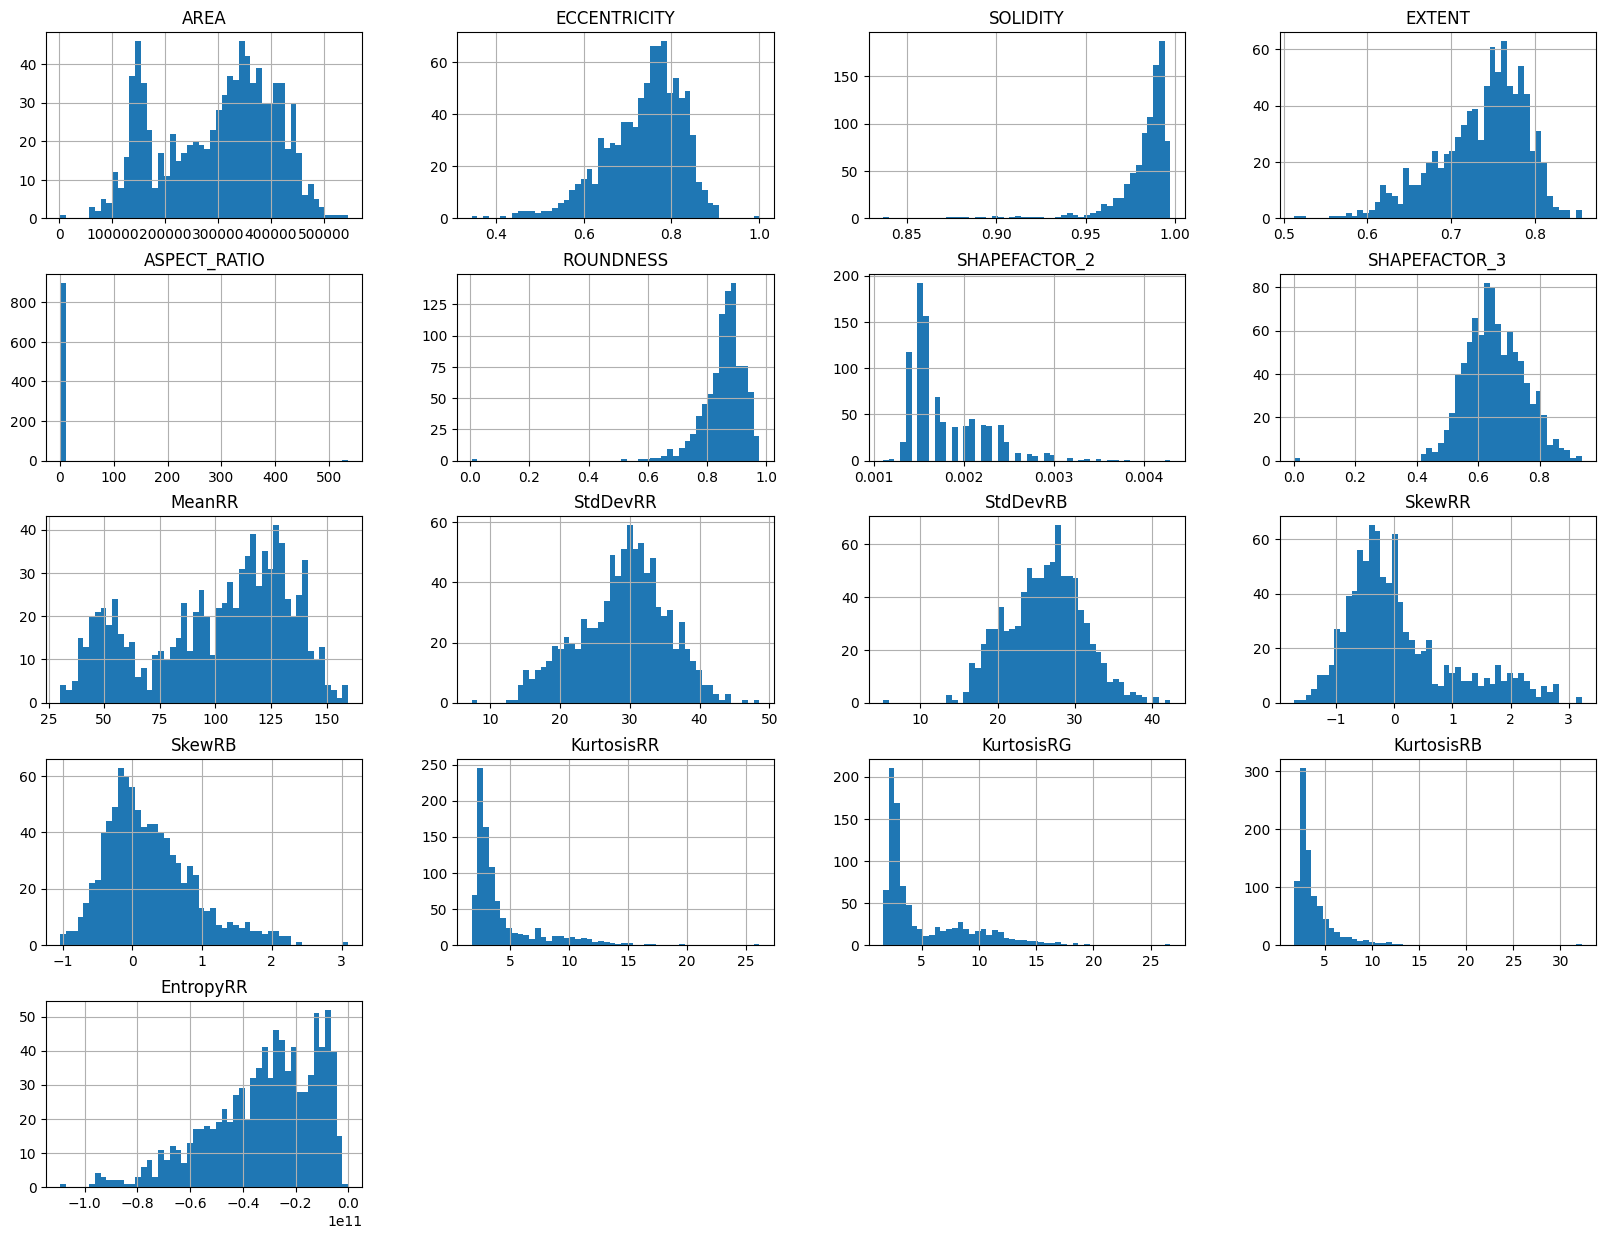

In [15]:
plt.figure(figsize=(20,20))
fruit_date_2.hist(bins=50, figsize=(20,15))
plt.show()

### Exploring the Target Variable

Let's explore the target column to see if the dataset is balanced or imbalanced.

In [16]:
target = fruit_date_2["Class"]

In [17]:
target.value_counts()

DOKOL     204
SAFAVI    199
ROTANA    166
DEGLET     98
SOGAY      94
IRAQI      72
BERHI      65
Name: Class, dtype: int64

In [18]:
# let's calculate percentage of each class so that we can see if the dataset is balanced or not
target.value_counts(normalize=True) * 100

DOKOL     22.717149
SAFAVI    22.160356
ROTANA    18.485523
DEGLET    10.913140
SOGAY     10.467706
IRAQI      8.017817
BERHI      7.238307
Name: Class, dtype: float64

So data is not highly imabalanced. But we still have more samples of "DOKOL", "SAFAVI" and "ROTANA" as compared to others. So we will need to split the data in a way that we have equal number of samples of each class in the training and testing data.

### Stratified Splitting of Data

Let's first split the data and then move on to further analysis.

In [19]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(fruit_date_2, fruit_date_2["Class"]):
    strat_train_set = fruit_date_2.loc[train_index]
    strat_test_set = fruit_date_2.loc[test_index]

Let's save the data to csv file so that we can use it directly

In [33]:
strat_train_set.to_csv("./dataset/strat_train_set.csv", index=False)
strat_test_set.to_csv("./dataset/strat_test_set.csv", index=False)

Let's compare overall proportion of each class and the proportion of each class in the training and testing data.

In [20]:
#overall
target.value_counts(normalize=True) * 100

DOKOL     22.717149
SAFAVI    22.160356
ROTANA    18.485523
DEGLET    10.913140
SOGAY     10.467706
IRAQI      8.017817
BERHI      7.238307
Name: Class, dtype: float64

In [21]:
strat_train_set["Class"].value_counts(normalize=True) * 100

DOKOL     22.701950
SAFAVI    22.144847
ROTANA    18.523677
DEGLET    10.863510
SOGAY     10.445682
IRAQI      8.077994
BERHI      7.242340
Name: Class, dtype: float64

In [22]:
strat_test_set["Class"].value_counts(normalize=True) * 100

DOKOL     22.777778
SAFAVI    22.222222
ROTANA    18.333333
DEGLET    11.111111
SOGAY     10.555556
IRAQI      7.777778
BERHI      7.222222
Name: Class, dtype: float64

Voila! We have equal number of samples of each class in the training and testing data. Now we can move on to further analysis.

Now we will not touch the test data. We will only use the training data for further analysis.

In [23]:
fruit_date_3 = strat_train_set.copy()

### Exploring the Features

Let's plot the bar plot for the target column.

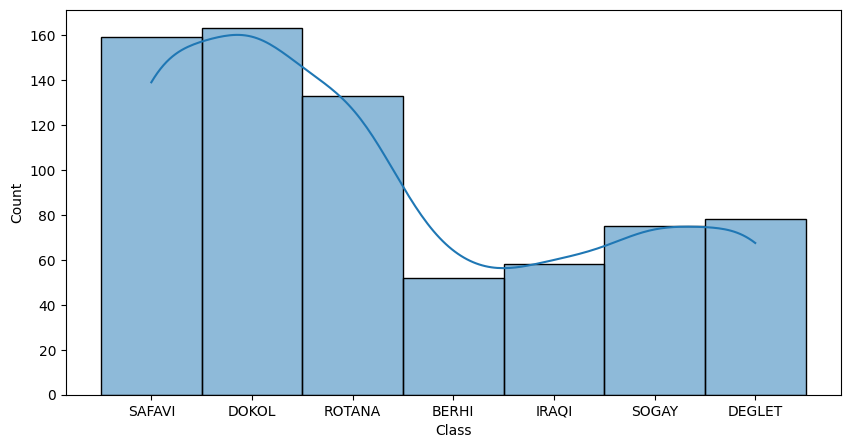

In [24]:
plt.figure(figsize=(10,5))
sns.histplot(data=fruit_date_3, x="Class", kde=True)
plt.show()

In [25]:
fruit_date_3.columns

Index(['AREA', 'ECCENTRICITY', 'SOLIDITY', 'EXTENT', 'ASPECT_RATIO',
       'ROUNDNESS', 'SHAPEFACTOR_2', 'SHAPEFACTOR_3', 'MeanRR', 'StdDevRR',
       'StdDevRB', 'SkewRR', 'SkewRB', 'KurtosisRR', 'KurtosisRG',
       'KurtosisRB', 'EntropyRR', 'Class'],
      dtype='object')

Let's take some features and plot their distribution for each class.

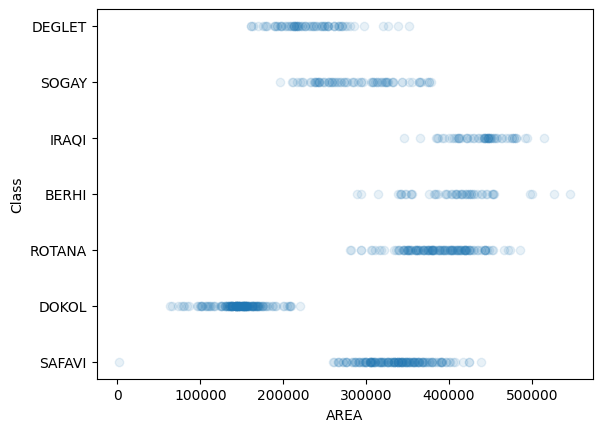

In [26]:
plt.plot(fruit_date_3["AREA"], fruit_date_3["Class"], "o", alpha=0.1,)
plt.xlabel("AREA")
plt.ylabel("Class")
plt.show()

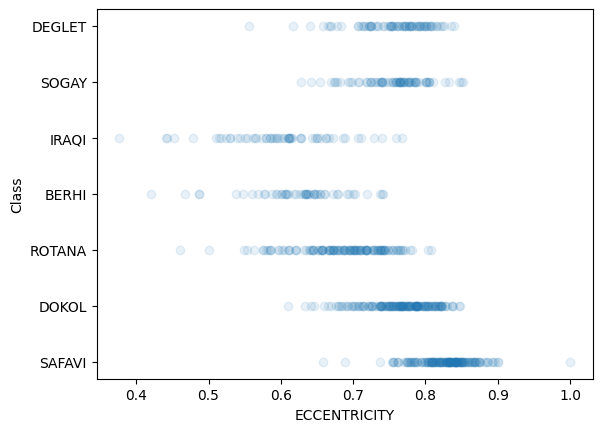

In [27]:
plt.plot(fruit_date_3["ECCENTRICITY"], fruit_date_3["Class"], "o", alpha=0.1)
plt.xlabel("ECCENTRICITY")
plt.ylabel("Class")
plt.show()

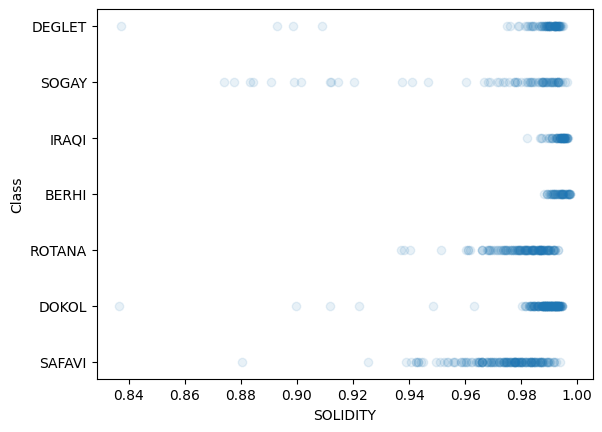

In [28]:
plt.plot(fruit_date_3["SOLIDITY"], fruit_date_3["Class"], "o", alpha=0.1)
plt.xlabel("SOLIDITY")
plt.ylabel("Class")
plt.show()

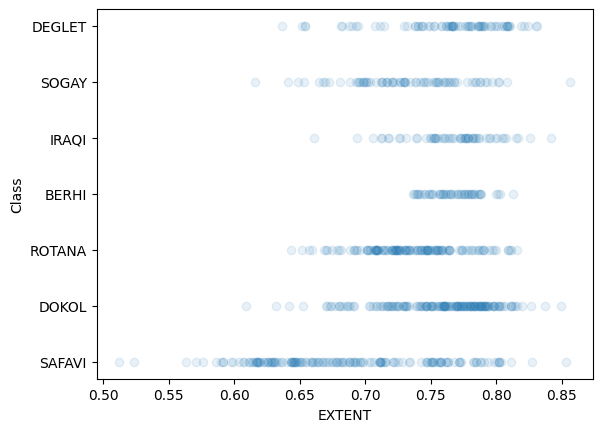

In [29]:
plt.plot(fruit_date_3["EXTENT"], fruit_date_3["Class"], "o", alpha=0.1)
plt.xlabel("EXTENT")
plt.ylabel("Class")
plt.show()

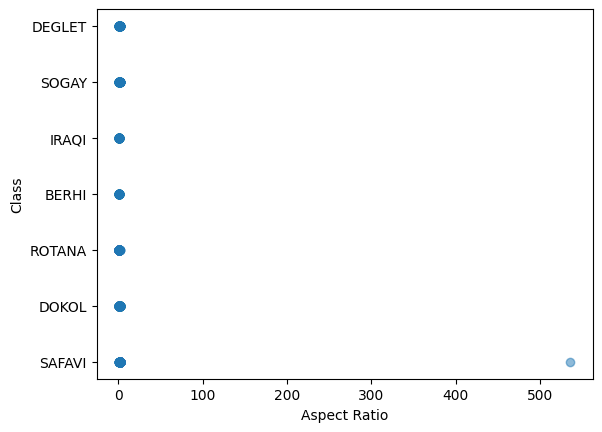

In [30]:
plt.plot(fruit_date_3["ASPECT_RATIO"], fruit_date_3["Class"], "o", alpha=0.5)
plt.xlabel("Aspect Ratio")
plt.ylabel("Class")
plt.show()

There is one outlier in ASPECT_RATIO for class "SAFAVI". Let's remove it.

In [31]:
fruit_date_3["ASPECT_RATIO"].min(), fruit_date_3["ASPECT_RATIO"].max()

(1.0793, 535.5257)

In [32]:
fruit_date_3.loc[fruit_date_3["ASPECT_RATIO"] == fruit_date_3["ASPECT_RATIO"].max()]

,AREA,ECCENTRICITY,SOLIDITY,EXTENT,ASPECT_RATIO,ROUNDNESS,SHAPEFACTOR_2,SHAPEFACTOR_3,MeanRR,StdDevRR,StdDevRB,SkewRR,SkewRB,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,Class
615,1987,1.0,0.8804,0.8528,535.5257,0.0048,0.0011,0.0017,94.5053,7.3038,5.1486,1.146,1.2258,7.3693,2.0304,7.4326,-162731632,SAFAVI


Outlier analysis of "ASPECT_RATIO"

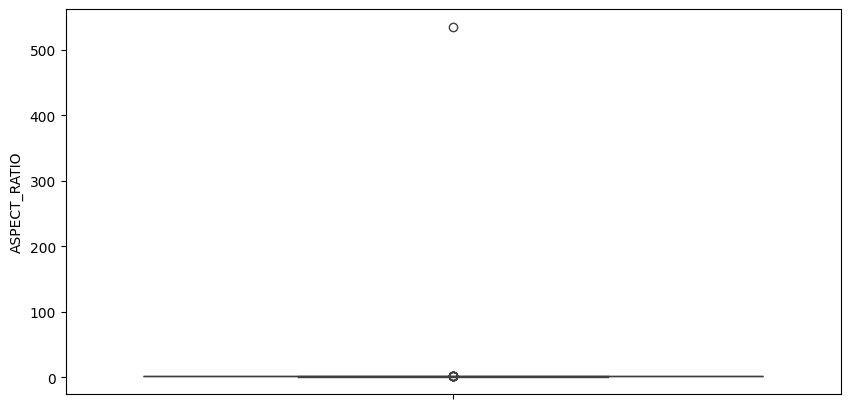

In [35]:
# plotting boxplot
plt.figure(figsize=(10,5))
sns.boxplot(fruit_date_3["ASPECT_RATIO"])
plt.show()

Let's remove this one outlier

In [39]:
fruit_date_3.shape # before removing outliers

(718, 18)

In [40]:
outlier = fruit_date_3.loc[fruit_date_3["ASPECT_RATIO"] == fruit_date_3["ASPECT_RATIO"].max()]

fruit_date_4 = fruit_date_3.drop(outlier.index)

In [41]:
fruit_date_4.shape # after removing outliers

(717, 18)

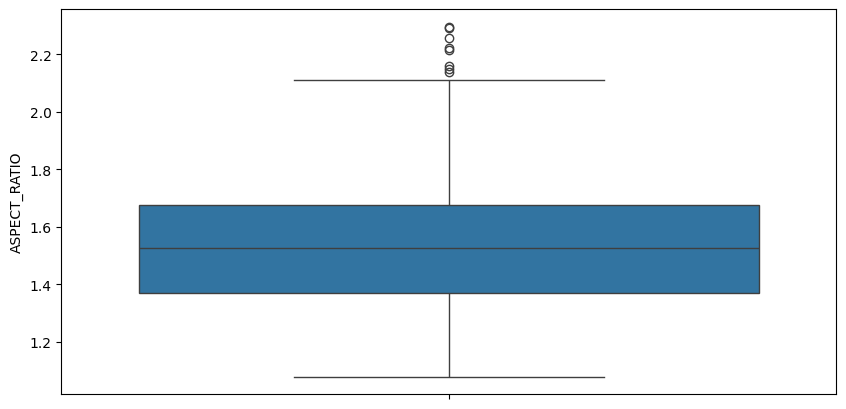

In [43]:
# plotting boxplot
plt.figure(figsize=(10,5))
sns.boxplot(fruit_date_4["ASPECT_RATIO"])
plt.show()

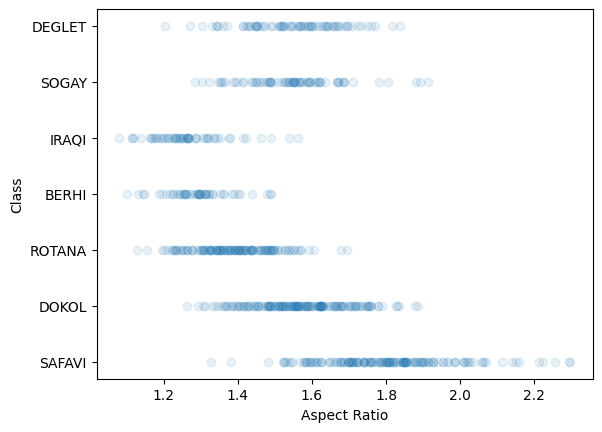

In [45]:
plt.plot(fruit_date_4["ASPECT_RATIO"], fruit_date_4["Class"], "o", alpha=0.1)
plt.xlabel("Aspect Ratio")
plt.ylabel("Class")
plt.show()

Now we are good to go further

In [46]:
fruit_date_4.columns

Index(['AREA', 'ECCENTRICITY', 'SOLIDITY', 'EXTENT', 'ASPECT_RATIO',
       'ROUNDNESS', 'SHAPEFACTOR_2', 'SHAPEFACTOR_3', 'MeanRR', 'StdDevRR',
       'StdDevRB', 'SkewRR', 'SkewRB', 'KurtosisRR', 'KurtosisRG',
       'KurtosisRB', 'EntropyRR', 'Class'],
      dtype='object')

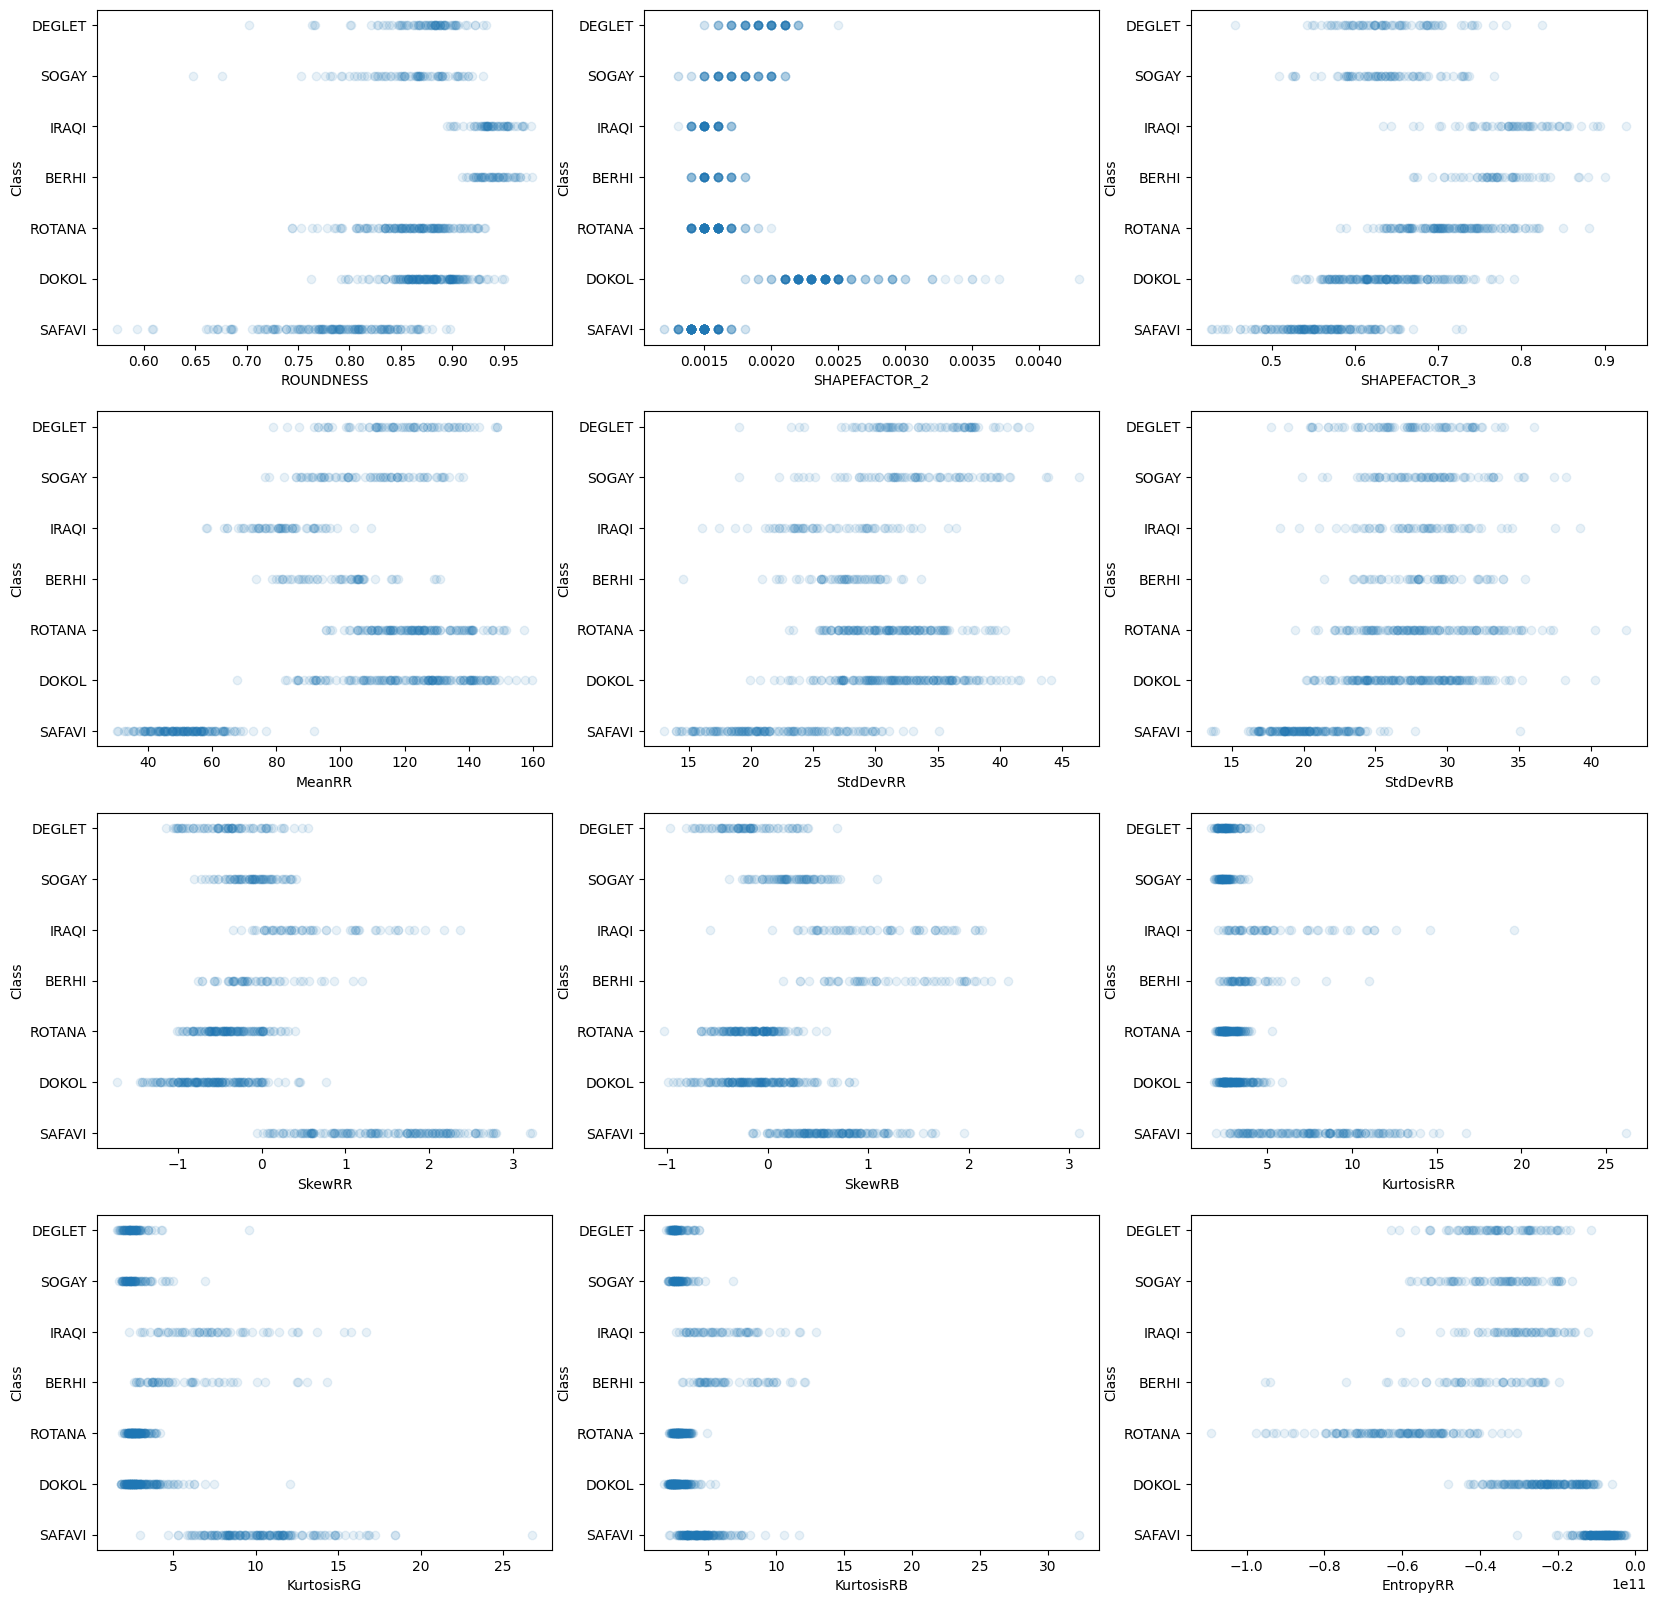

In [47]:
tmp = ['ROUNDNESS', 'SHAPEFACTOR_2', 'SHAPEFACTOR_3', 'MeanRR', 'StdDevRR',
       'StdDevRB', 'SkewRR', 'SkewRB', 'KurtosisRR', 'KurtosisRG',
       'KurtosisRB', 'EntropyRR']
y = "Class"

plt.figure(figsize=(20,20))
for i, col in enumerate(tmp):
    plt.subplot(4, 3, i+1)
    plt.plot(fruit_date_4[col], fruit_date_4[y], "o", alpha=0.1)
    plt.xlabel(col)
    plt.ylabel(y)
    
plt.show()

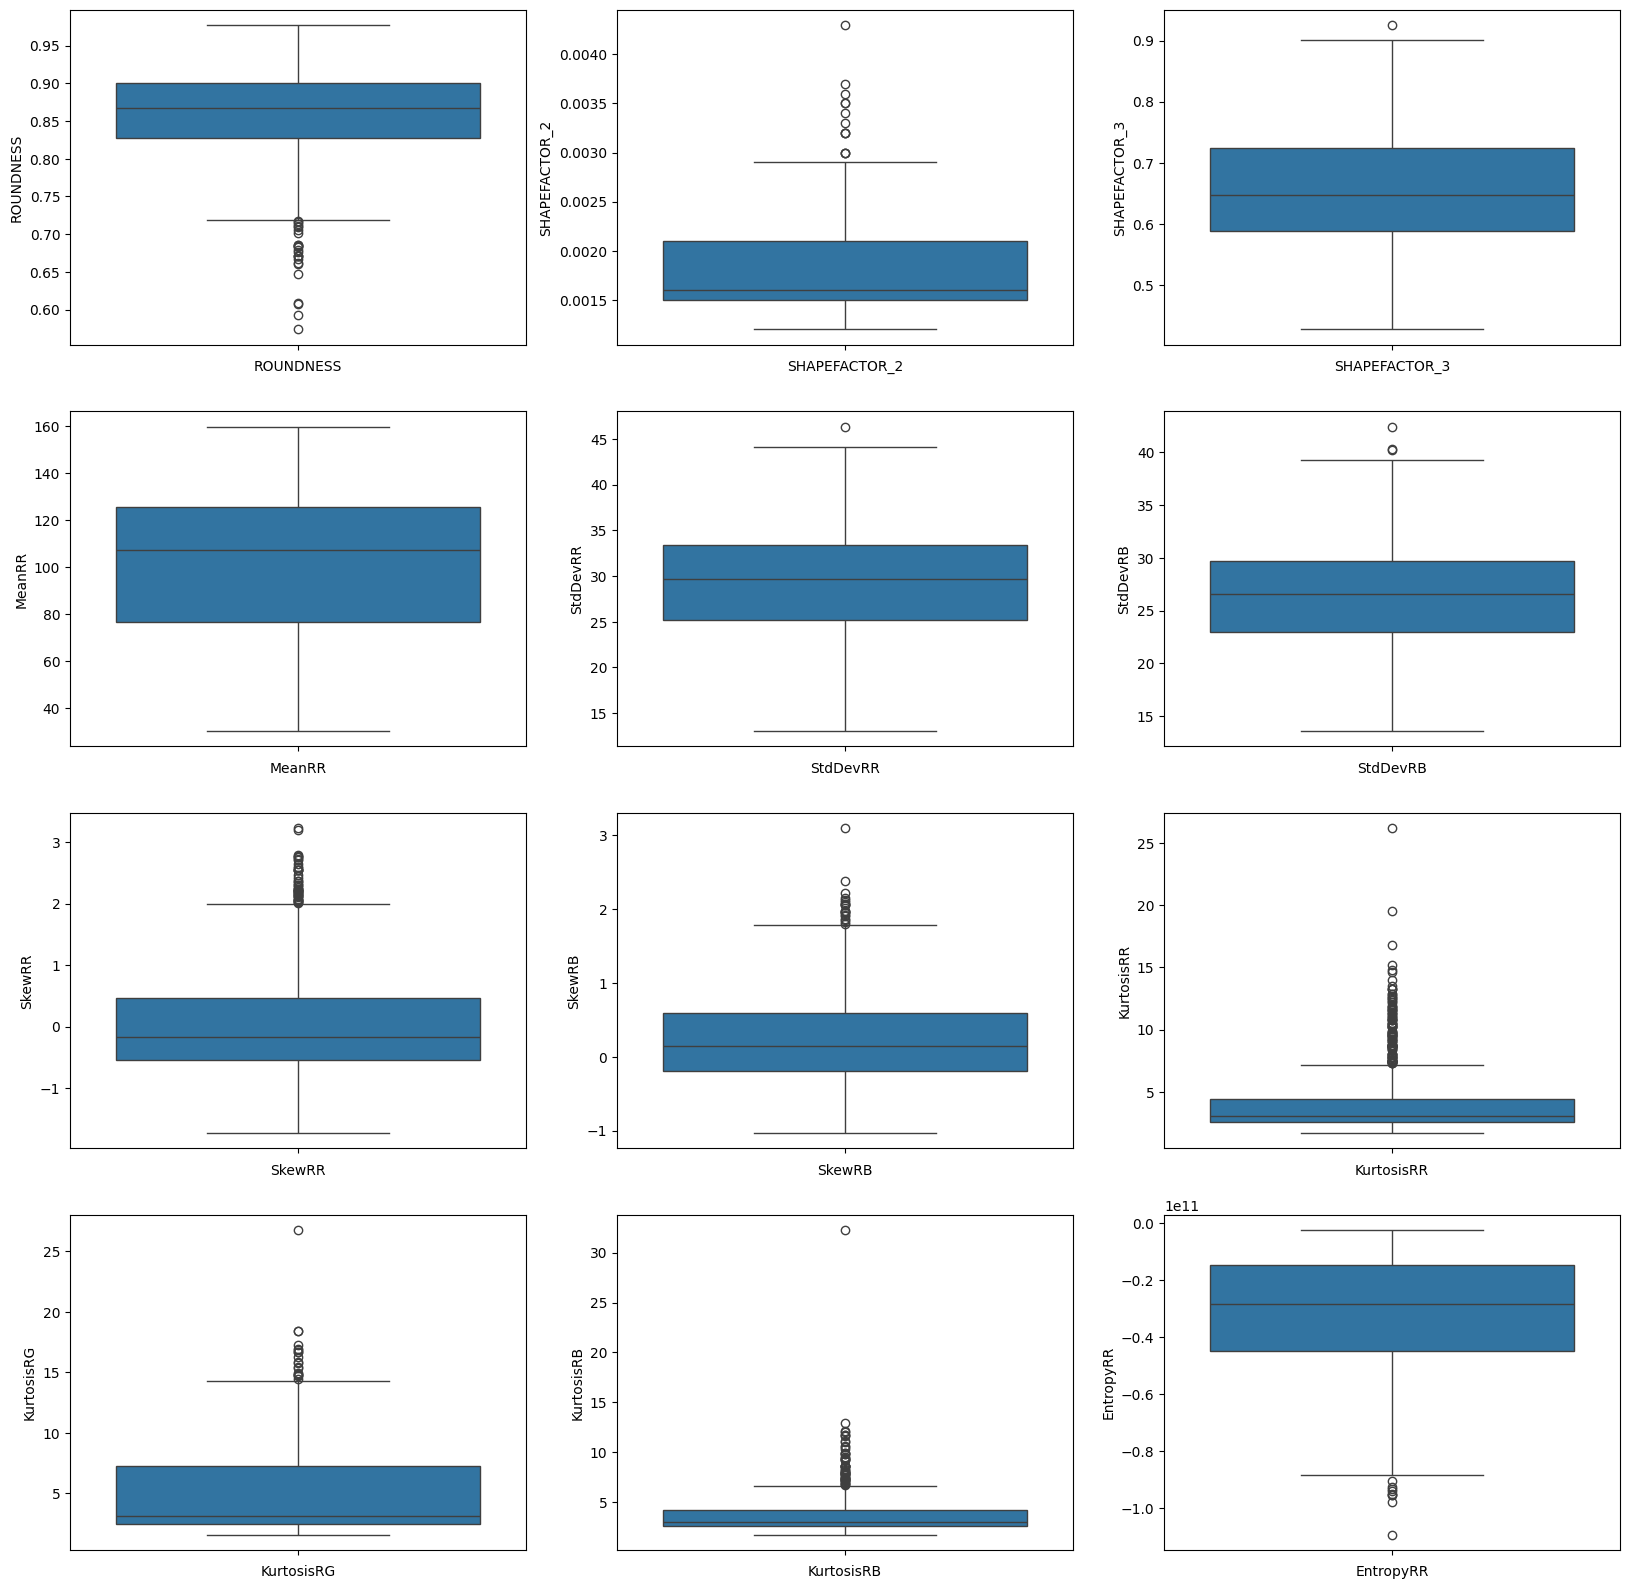

In [48]:
plt.figure(figsize=(20,20))
for i, col in enumerate(tmp):
    plt.subplot(4, 3, i+1)
    sns.boxplot(fruit_date_4[col])
    plt.xlabel(col)
    
plt.show()

Now we can move to data preparation and model building.

In [49]:
fruit_date_4.shape

(717, 18)

In [50]:
strat_train_set.shape

(718, 18)

Saving preprocessed data to csv file.

In [51]:
fruit_date_4.to_csv("./dataset/strat_train_set.csv", index=False)

## Model Building

### Loading Preprocessed Data

In [2]:
strat_train_set = pd.read_csv("./dataset/strat_train_set.csv")

strat_test_set = pd.read_csv("./dataset/strat_test_set.csv")

strat_train_set.shape, strat_test_set.shape

((717, 18), (180, 18))

In [53]:
strat_train_set.head()

,AREA,ECCENTRICITY,SOLIDITY,EXTENT,ASPECT_RATIO,ROUNDNESS,SHAPEFACTOR_2,SHAPEFACTOR_3,MeanRR,StdDevRR,StdDevRB,SkewRR,SkewRB,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,Class
0,298963,0.6581,0.9424,0.6671,1.3282,0.8361,0.0018,0.7285,63.3068,28.1020,22.9453,2.1074,0.8237,8.7354,6.6662,3.9821,-12710694912,SAFAVI
1,159802,0.7674,0.9920,0.6801,1.5596,0.8570,0.0023,0.6380,147.3548,36.0944,25.8574,-0.8871,-0.3546,3.0208,2.3733,2.4878,-37314162688,DOKOL
2,419881,0.6439,0.9893,0.7533,1.3070,0.8861,0.0015,0.7513,122.7984,30.7302,27.1093,-0.5508,-0.1357,2.7553,2.2804,2.8602,-65871720448,ROTANA
3,376389,0.8405,0.9852,0.7680,1.8457,0.8149,0.0014,0.5409,53.6526,21.0930,19.0449,0.9572,0.7969,5.8969,11.4115,4.8959,-10489750528,SAFAVI
4,451414,0.6796,0.9970,0.7877,1.3631,0.9395,0.0014,0.7267,115.6213,33.6642,33.8446,0.0606,0.9431,3.0703,3.4163,4.9168,-63711666176,BERHI


### Splitting Features and Target

In [3]:
X_train = strat_train_set.drop("Class", axis=1)
y_train = strat_train_set["Class"]

X_test = strat_test_set.drop("Class", axis=1)
y_test = strat_test_set["Class"]

### Handling Categorical Target Column

In [62]:
y_train.value_counts()

DOKOL     163
SAFAVI    158
ROTANA    133
DEGLET     78
SOGAY      75
IRAQI      58
BERHI      52
Name: Class, dtype: int64

In [4]:
map_dict = {"DOKOL": 0, "SAFAVI": 1, "ROTANA": 2,
            "DEGLET": 3, "SOGAY": 4, "IRAQI": 5, "BERHI": 6
            }

In [5]:
# map the target variable to each number
y_train = y_train.map(map_dict)
y_test = y_test.map(map_dict)

y_train.value_counts()

0    163
1    158
2    133
3     78
4     75
5     58
6     52
Name: Class, dtype: int64

### Pipline for Preprocessing

In [6]:
pipline = Pipeline([
    ("scaler", StandardScaler())
])  

In [7]:
X_train_tr = pipline.fit_transform(X_train)
X_test_tr = pipline.transform(X_test)

In [66]:
X_train_tr

array([[-2.49396279e-03, -9.02710155e-01, -2.10232451e+00, ...,
         4.19673587e-01,  9.62092325e-02,  9.38987634e-01],
       [-1.30476788e+00,  3.41784635e-01,  5.46413110e-01, ...,
        -7.29627557e-01, -6.15124244e-01, -2.60248614e-01],
       [ 1.12906127e+00, -1.06439200e+00,  4.02227795e-01, ...,
        -7.54498873e-01, -4.37850212e-01, -1.65221737e+00],
       ...,
       [ 7.64032281e-01,  7.53511669e-02,  2.63382678e-01, ...,
        -6.44679560e-01, -5.20679647e-01, -1.19884335e+00],
       [ 9.21902381e-01,  4.00544253e-02,  6.90598424e-01, ...,
        -3.88796051e-02,  2.30109071e+00, -6.30257557e-01],
       [ 8.40674612e-01, -6.14643200e-01,  5.09031732e-01, ...,
        -4.05550817e-01, -1.36236820e-01, -2.74743839e+00]])

In [67]:
X_train_tr.shape

(717, 17)

## Let's try different models

### Binary Classification

Let's simplify the process and first try to identify only one class. That is we will train a binary classifier to identify if the fruit is "DOKOL" or not.

In [97]:
y_train_dokol = (y_train == 0) # true for all "DOKOL" and false for all other classes
y_test_dokol = (y_test == 0)

Now let's pick classifier and train it.

Good place to start with is `SGDClassifier`. Let's train it.

In [98]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_tr, y_train_dokol)

SGDClassifier(random_state=42)

Now let's predict on one instance

In [106]:
X_new_tr = X_test_tr[:3]

y_pred = sgd_clf.predict(X_new_tr)
y_pred

array([False,  True, False])

In [108]:
# original
y_test_dokol[:3].values

array([False,  True, False])

#### Performance Metrics

##### Cross Validation

In [109]:
cross_val_score(sgd_clf, X_train_tr, y_train_dokol, cv=3, scoring="accuracy")

array([0.9748954, 0.9665272, 0.9665272])

In [110]:
y_train_pred = cross_val_predict(sgd_clf, X_train_tr, y_train_dokol, cv=3)

##### Confusion Matrix

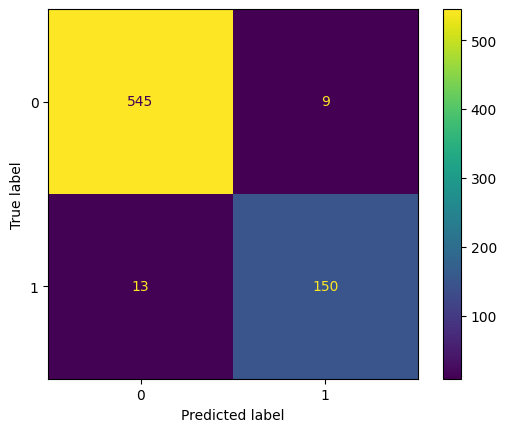

In [111]:

cm = confusion_matrix(y_train_dokol, y_train_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

##### Precision, Recall, F1 Score

In [112]:
precision_score(y_train_dokol, y_train_pred)

0.9433962264150944

In [113]:
recall_score(y_train_dokol, y_train_pred)

0.9202453987730062

Our model when it claims date is "dokol", it is correct 94% times and moreover it able to detect only 92% of the "dokol" dates.

In [114]:
f1_score(y_train_dokol, y_train_pred)

0.9316770186335405

##### Precision-Recall Curve

"decision_function" method gives the confidence score of the model.

In [116]:
y_scores = cross_val_predict(sgd_clf, X_train_tr, y_train_dokol, cv=3, method="decision_function")

In [117]:
precisions, recall, thresholds = precision_recall_curve(y_train_dokol, y_scores)

In [120]:
precisions.shape, thresholds.shape

((718,), (717,))

In [132]:
recall_90_precision = recall[np.argmax(precisions >= 0.90)] # this gives first value of recall where precision is > 0.90
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

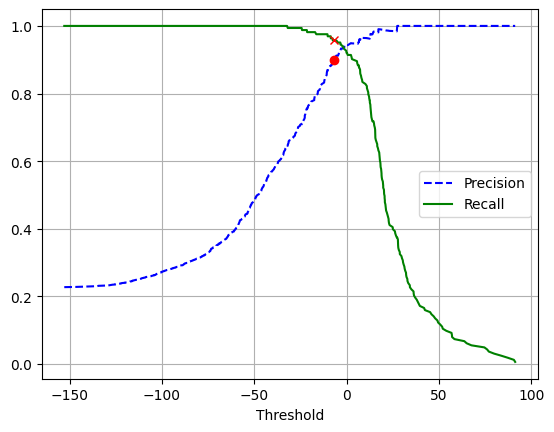

In [134]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.plot(threshold_90_precision, 0.9, "ro")
plt.plot(threshold_90_precision, recall_90_precision, "rx")
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.grid(True)
plt.show()

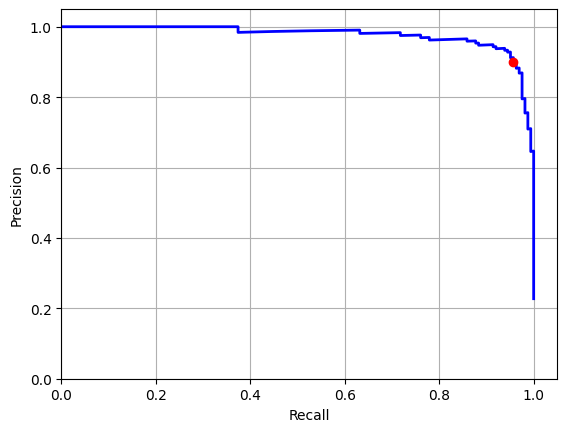

In [136]:
plt.plot(recall, precisions, "b-", linewidth=2)
plt.plot(recall_90_precision, 0.9, "ro")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0,1.05,0,1.05])
plt.grid(True)
plt.show()

Precision starts to fall sharply after around 90% recall. We want to select a precision/recall tradeoff just before that drop.

Let's suppose we decide to aim at 90% precision.

In [137]:
threshold_90_precision

-6.857787808829627

In [138]:
y_train_pred_90 = y_scores > threshold_90_precision

In [139]:
precision_score(y_train_dokol, y_train_pred_90)

0.9069767441860465

In [140]:
recall_score(y_train_dokol, y_train_pred_90)

0.9570552147239264

##### ROC Curve

In [141]:
fpr, tpr, thresholds = roc_curve(y_train_dokol, y_scores)

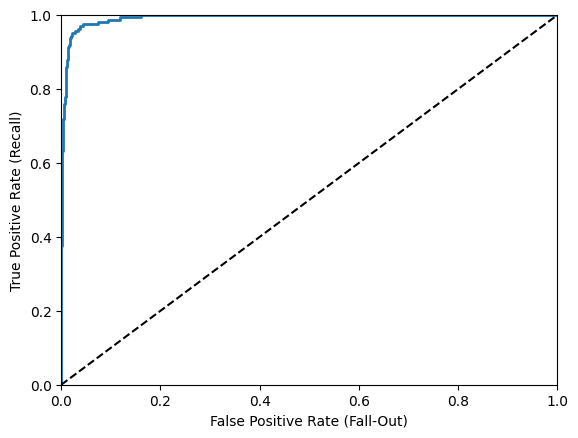

In [143]:
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], "k--")
plt.axis([0,1 , 0, 1])
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

##### ROC AUC Score

In [144]:
roc_auc_score(y_train_dokol, y_scores)

0.9931120019490155

### Multiclass classification

#### 1. Logistic Regression

In [72]:
lr = LogisticRegression()
lr.fit(X_train_tr, y_train)

LogisticRegression()

In [147]:
X_new = X_test_tr[:1]
X_new

array([[ 0.28561195,  1.22078736,  0.50903173, -1.01262931,  1.53088049,
        -0.46534513, -0.92693166, -1.3322861 , -1.56862011, -1.64722298,
        -0.70897951,  0.42110431, -0.13166118,  0.05076148,  1.04362505,
        -0.28037908,  1.18568622]])

In [148]:
y_new = y_test[:1]
y_new

722    1
Name: Class, dtype: int64

In [76]:
lr.predict(X_new)

array([1])

In [79]:
y_pred = lr.predict(X_test_tr)

accuracy_score(y_test, y_pred)

0.95

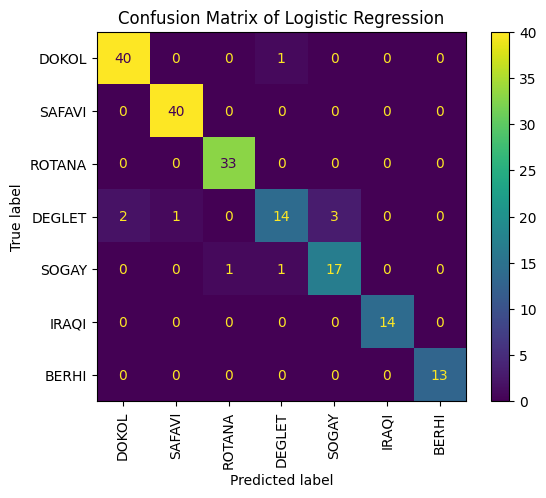

In [91]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=list(map_dict.keys())).plot(xticks_rotation="vertical")
plt.title("Confusion Matrix of Logistic Regression")
plt.show()

In [92]:
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.9486190058679298
Recall: 0.95
F1 Score: 0.9480631440827115


#### 2. Random Forest Classifier

In [146]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train_tr, y_train)

RandomForestClassifier()

In [149]:
forest_clf.predict(X_new)

array([1])

In [150]:
y_new

722    1
Name: Class, dtype: int64

In [152]:
cross_val_score(forest_clf, X_train_tr, y_train, cv=3, scoring="accuracy")

array([0.84937238, 0.85774059, 0.87447699])

In [153]:
y_pred = forest_clf.predict(X_test_tr)

In [154]:
accuracy_score(y_test, y_pred)

0.9333333333333333

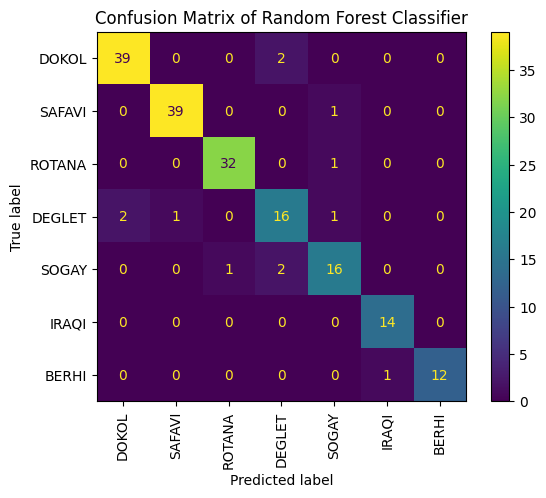

In [155]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=list(map_dict.keys())).plot(xticks_rotation="vertical")
plt.title("Confusion Matrix of Random Forest Classifier")
plt.show()

In [156]:
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.9337037037037037
Recall: 0.9333333333333333
F1 Score: 0.9333180076628352


#### 3. KNeighbors Classifier

In [9]:


knn = KNeighborsClassifier()
knn.fit(X_train_tr, y_train)

KNeighborsClassifier()

In [12]:
X_new = X_test_tr[:1]
y_actual = y_test[:1]

In [13]:
y_pred = knn.predict(X_new)

In [18]:
y_pred, y_actual.values

(array([1]), array([1]))

In [19]:
y_pred = knn.predict(X_test_tr)

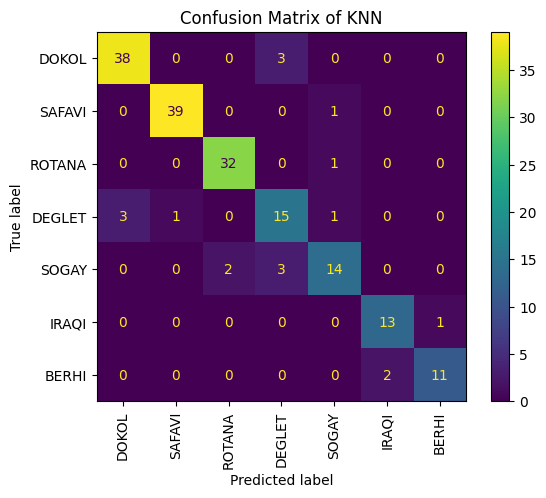

In [20]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=list(map_dict.keys())).plot(xticks_rotation="vertical")
plt.title("Confusion Matrix of KNN")
plt.show()

In [21]:
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.9002310924369747
Recall: 0.9
F1 Score: 0.8995890906492985


#### 4. XGBoost Classifier

In [25]:
xgb = XGBClassifier()
xgb.fit(X_train_tr, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [26]:
y_pred = xgb.predict(X_test_tr)

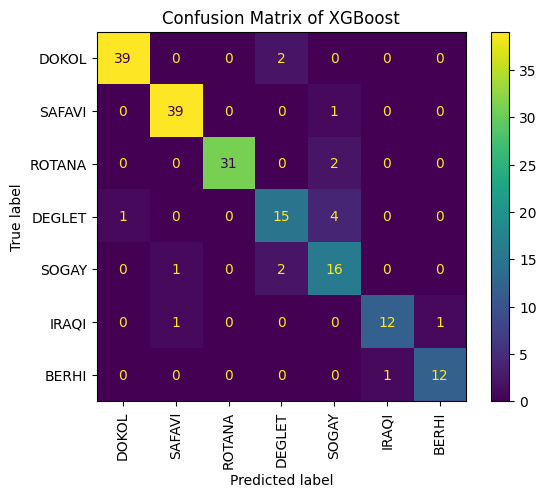

In [28]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=list(map_dict.keys())).plot(xticks_rotation="vertical")
plt.title("Confusion Matrix of XGBoost")
plt.show()

In [29]:
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.9164095688857786
Recall: 0.9111111111111111
F1 Score: 0.9126333350291684


### Analysis of all classic ML models

In [12]:
# intializing models
lr = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier()
xgb = XGBClassifier()

models = [lr, rnd_clf, knn, xgb]

analysis_report = []

for model in models:
    model.fit(X_train_tr, y_train)
    y_pred = model.predict(X_test_tr)
    
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    cm = confusion_matrix(y_test, y_pred)
    
    analysis_report.append({"Model": model.__class__.__name__,
                            "Precision": precision,
                            "Recall": recall,
                            "F1 Score": f1,
                            "Confusion Matrix": cm
                            })
    

In [14]:
header = ["Model", "Precision", "Recall", "F1 Score"]
analysis_report_df = pd.DataFrame(analysis_report, columns=header)

In [15]:
analysis_report_df

,Model,Precision,Recall,F1 Score
0,LogisticRegression,0.948619,0.950000,0.948063
1,RandomForestClassifier,0.945509,0.944444,0.944682
2,KNeighborsClassifier,0.900231,0.900000,0.899589
3,XGBClassifier,0.916410,0.911111,0.912633


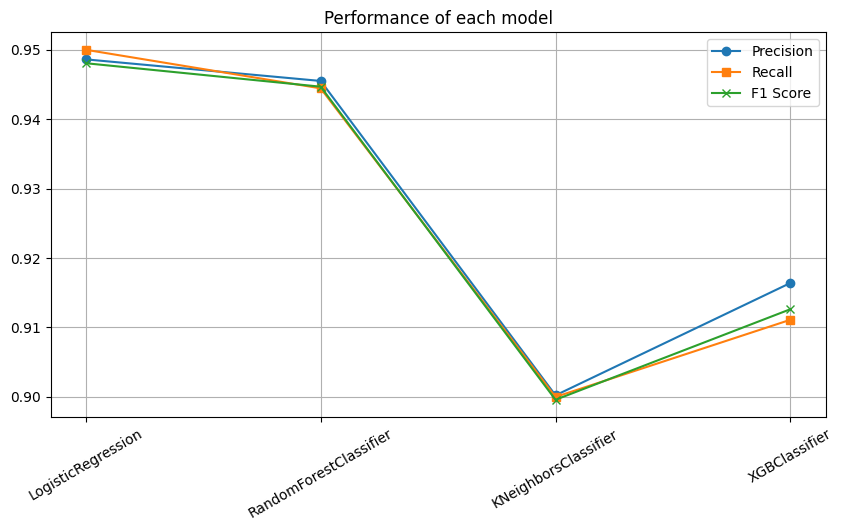

In [32]:
# plotting performance of each model
plt.figure(figsize=(10,5))
plt.plot(analysis_report_df["Model"], analysis_report_df["Precision"], "o-", label="Precision")
plt.plot(analysis_report_df["Model"], analysis_report_df["Recall"], "s-", label="Recall")
plt.plot(analysis_report_df["Model"], analysis_report_df["F1 Score"], "x-", label="F1 Score")
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.title("Performance of each model")
plt.show()

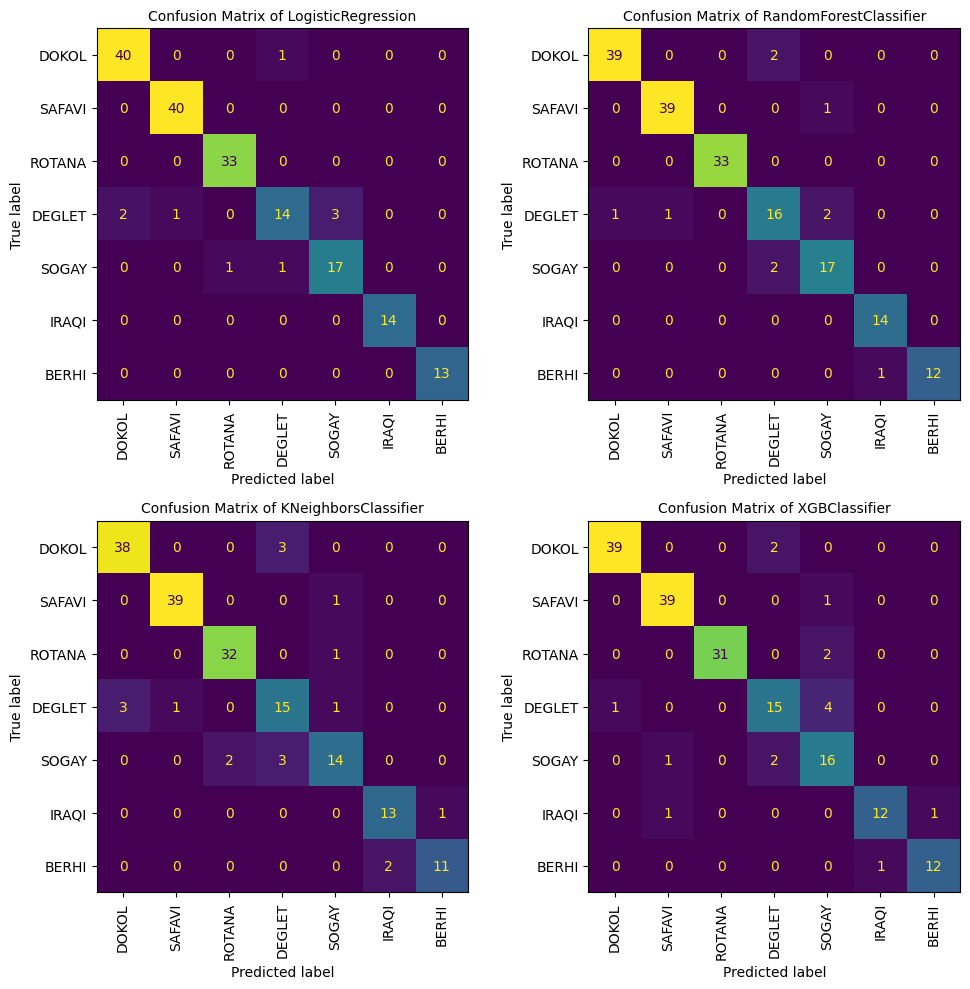

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for ax, model, report in zip(axs.flatten(), models, analysis_report):
    ConfusionMatrixDisplay(report["Confusion Matrix"], display_labels=list(map_dict.keys())).plot(ax=ax, xticks_rotation="vertical", colorbar=False)
    ax.set_title(f"Confusion Matrix of {model.__class__.__name__}", fontsize=10)

plt.tight_layout()
plt.show()


### 5. Neural Network (Deep Learning)

In [77]:
keras.backend.clear_session()
tf.random.set_seed(42)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model_1 = keras.models.Sequential([
    keras.layers.InputLayer(shape=X_train_tr.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(7, activation="softmax")
])
model_1._name = "30_Deep_20"

model_1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X_train_tr, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_cb], verbose=0)
model_1.save(f"./models/{model_1._name}.keras")

y_pred = model.predict(X_test_tr, verbose=0)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

In [78]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.8986336698531819
Recall: 0.9
F1 Score: 0.8975248527394497


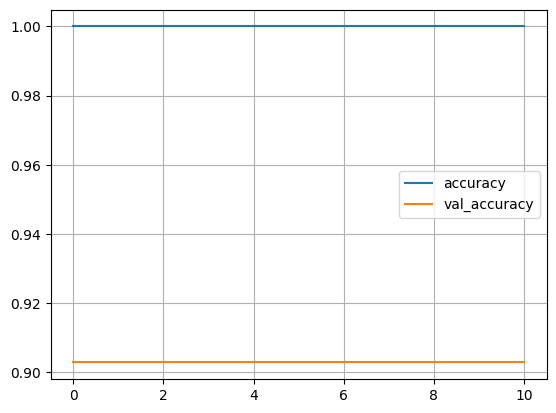

In [81]:
plt.plot(h.history["accuracy"], label="accuracy")
plt.plot(h.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [83]:
analysis_report_df.loc[4] = ["30_Deep_20", precision, recall, f1]
analysis_report_df

,Model,Precision,Recall,F1 Score
0,LogisticRegression,0.948619,0.950000,0.948063
1,RandomForestClassifier,0.945509,0.944444,0.944682
2,KNeighborsClassifier,0.900231,0.900000,0.899589
3,XGBClassifier,0.916410,0.911111,0.912633
4,30_Deep_20,0.898634,0.900000,0.897525
